### articles analysis

In [1]:
import pandas as pd
from urllib.parse import unquote

articles = pd.read_csv('data/wikispeedia_paths-and-graph/articles.tsv', 
                      sep='\t', 
                      comment='#', 
                      header=None,
                      names=['article'])
# unquote the titles
articles = articles.map(unquote)
articles.head()

,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


### categories analysis

In [2]:
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv',
                        sep='\t',
                        comment='#',
                        header=None,
                        names=['article', 'category'])
# unquote 
categories = categories.map(unquote)
categories.head()

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [ ]:

nodes = {}
# Process each row to build the nodes
for _, row in categories.iterrows():
    category_parts = row['category'].split('.')
    article = row['article']
    path_parts = category_parts + [article]

    for i, part in enumerate(path_parts):
        node_id = '.'.join(category_parts[:i] + [part])
        parent_id = '.'.join(category_parts[:i]) if i > 0 else ''
        if node_id not in nodes:
            nodes[node_id] = {
                'id': node_id,
                'name': part,
                'parent': parent_id,
                'size': 0
            }
        nodes[node_id]['size'] += 1

nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
# Calculate relative sizes
parent_sizes = nodes_df.set_index('id')['size'].to_dict()
nodes_df['relative_size'] = nodes_df.apply(
    lambda row: (row['size'] / parent_sizes.get(row['parent'], row['size'])) * 100
    if parent_sizes.get(row['parent'], row['size']) else 100,
    axis=1
)

In [ ]:
import random
import plotly.graph_objects as go

def create_treemap(ids, labels, parents, values, hover_text):

    # generate random deep colors
    colors = [f"#{random.randint(30, 150):02x}{random.randint(30, 150):02x}{random.randint(30, 150):02x}" for _ in ids]

    fig = go.Figure(go.Treemap(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        hovertext=hover_text,
        hoverinfo="text",
        maxdepth=2,
        branchvalues="total",
        marker=dict(colors=colors, line=dict(width=1, color='#000000')),
        textfont=dict(color='white', size=16), 
        textposition="middle center", 
        hoverlabel=dict(bgcolor='#2c3e50', font=dict(color='white'))
    ))

    fig.update_layout(
        width=1000,
        height=800,
        title=dict(
            text="Category-Article Treemap",
            xanchor='center',
            x=0.5,
            yanchor='top',
            font=dict(color='white')
        ),
        paper_bgcolor='#111111',
        plot_bgcolor='#111111',
        font=dict(color='white')
    )

    return fig

In [74]:
ids, parents, values = nodes_df['id'], nodes_df['parent'], nodes_df['size']

# Fill NaN values in relative_size with 0 before rounding
nodes_df['relative_size'] = nodes_df['relative_size'].fillna(0)

labels = nodes_df.apply(
    lambda row: f"{row['name']}" if row['size'] == 1 else f"{row['name']}<br>({row['relative_size']:.2f}%)",
    axis=1
)

hover_text =  nodes_df.apply(
    lambda row: "Article" if row['size'] == 1 else
    f"Full Category: {row['id']}<br>"
    f"Size: {row['size']}<br>"
    f"Percentage: {row['relative_size']:.2f}%",
    axis=1
)
fig = create_treemap(ids, labels, parents, values, hover_text)
fig.show()

### links analysis

In [6]:
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv',
                     sep='\t',
                     comment='#',
                     header=None,
                     names=['from', 'to'])
# unquote
links = links.map(unquote)
links.head()

,from,to
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


path analysis

In [7]:
def load_and_unquote_paths(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=column_names)
    df['path'] = df['path'].map(unquote)
    return df

paths_finished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_finished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','rating'])
paths_finished.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [8]:
# clean paths by removing back navigation ('<') and corresponding nodes.

cleaned_paths = []

for path in paths_finished['path']:
    nodes = path.split(';')
    stack = []
    
    for node in nodes:
        if node == '<':
            if stack:  
                stack.pop()
        else:
            stack.append(node)
    
    cleaned_path = ';'.join(stack)
    cleaned_paths.append(cleaned_path)

paths_finished['path'] = cleaned_paths

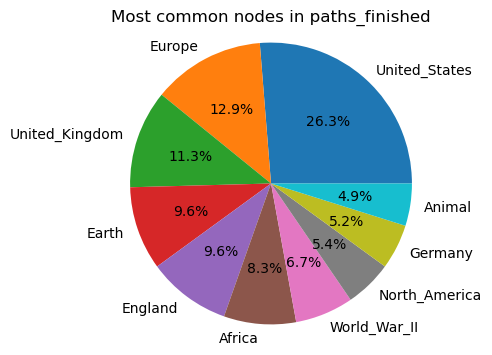

In [9]:
from collections import Counter

all_paths = ';'.join(paths_finished['path'])
nodes = all_paths.split(';')
node_counts = Counter(nodes)

import matplotlib.pyplot as plt

# pie chart of the most common nodes
top_nodes = node_counts.most_common(10)
# split the nodes and counts
nodes, counts = zip(*top_nodes)
plt.figure(figsize=(4,4))
plt.title('Most common nodes in paths_finished')
plt.pie(counts, labels=nodes, autopct='%1.1f%%')
plt.axis('equal')
plt.show()


In [10]:
# find the easiest path
paths_finished['path'].value_counts().head(10)

path
Brain;Computer_science;Information;Communication;Telephone             160
Bird;Fish;Whale_shark;Shark;Great_white_shark                           90
Asteroid;Earth;Europe;Norway;Viking                                     83
Theatre;India;Mammal;Zebra                                              79
Theatre;Dance;Animal;Mammal;Zebra                                       74
Brain;Computer_science;Internet;World_Wide_Web;Telephone                44
Brain;Computer_science;Internet;Information;Communication;Telephone     44
Batman;Scotland;Agriculture;Fossil_fuel;Wood                            38
Brain;Animal;Human;Communication;Telephone                              30
Pyramid;Ancient_Egypt;Cereal;Seed;Bean                                  30
Name: count, dtype: int64

In [11]:
paths_unfinished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','target','type'])
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [12]:
with open('data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as file:
    data = file.readlines()
# remove comment 
data = [line.strip() for line in data if not line.startswith('#') and line.strip()]
# convert the data into a matrix
distance_matrix = [list(line) for line in data]
# convert the matrix into a DataFrame
df = pd.DataFrame(distance_matrix)
df.replace('_', pd.NA, inplace=True)
df = df.apply(pd.to_numeric)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4594,4595,4596,4597,4598,4599,4600,4601,4602,4603
0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
1,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
2,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
3,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
4,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


Mean shortest-path distance: 3.201729547596255
Median shortest-path distance: 3.0


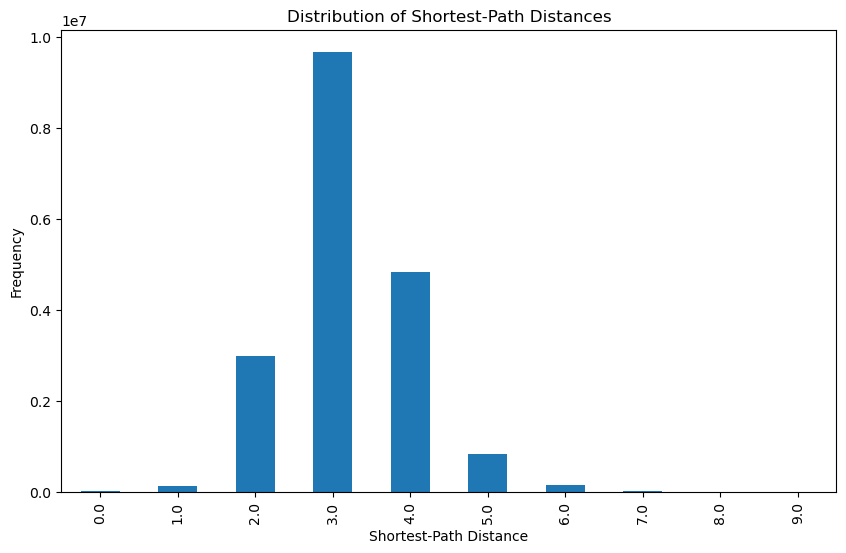

In [13]:
import matplotlib.pyplot as plt

mean_distance = df.stack().mean()
median_distance = df.stack().median()
distance_distribution = df.stack().value_counts().sort_index()

print(f"Mean shortest-path distance: {mean_distance}")
print(f"Median shortest-path distance: {median_distance}")

plt.figure(figsize=(10, 6))
distance_distribution.plot(kind='bar')
plt.title('Distribution of Shortest-Path Distances')
plt.xlabel('Shortest-Path Distance')
plt.ylabel('Frequency')
plt.show()